**Задание**
1. Проведите анализ с помощью SSA в любом из временных рядов с первого занятия.
2. При желании можете воспользоваться своим временным рядом — работа, Kaggle и т. д.
3. Посмотрите на результаты с разными длинами окон.
4. Обязательно визуализируйте результаты аналогично материалу с занятия.

In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [15]:
# Возьмем для анализа следующий ВР
female_births = pd.read_csv("/content/daily-total-female-births-in-cal.csv")

In [16]:
all_series = {"Daily total female births in California": female_births["Count"]}

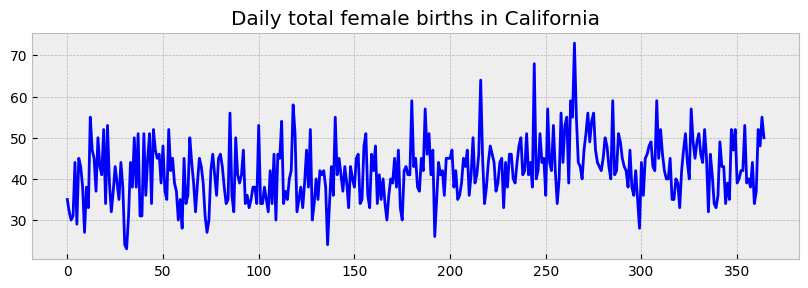

In [17]:
#Отобразим выбранный ВР

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [18]:
'''
Функция для использования теста Дики-Фуллера
для проверки временного ряда на стационарность
'''

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

Построим график автокорреляции, частичной автокорреляции
для визуального анализа наличия/отсутствия элементов временного ряда (тренд/сезонность/размах/шум)

In [19]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


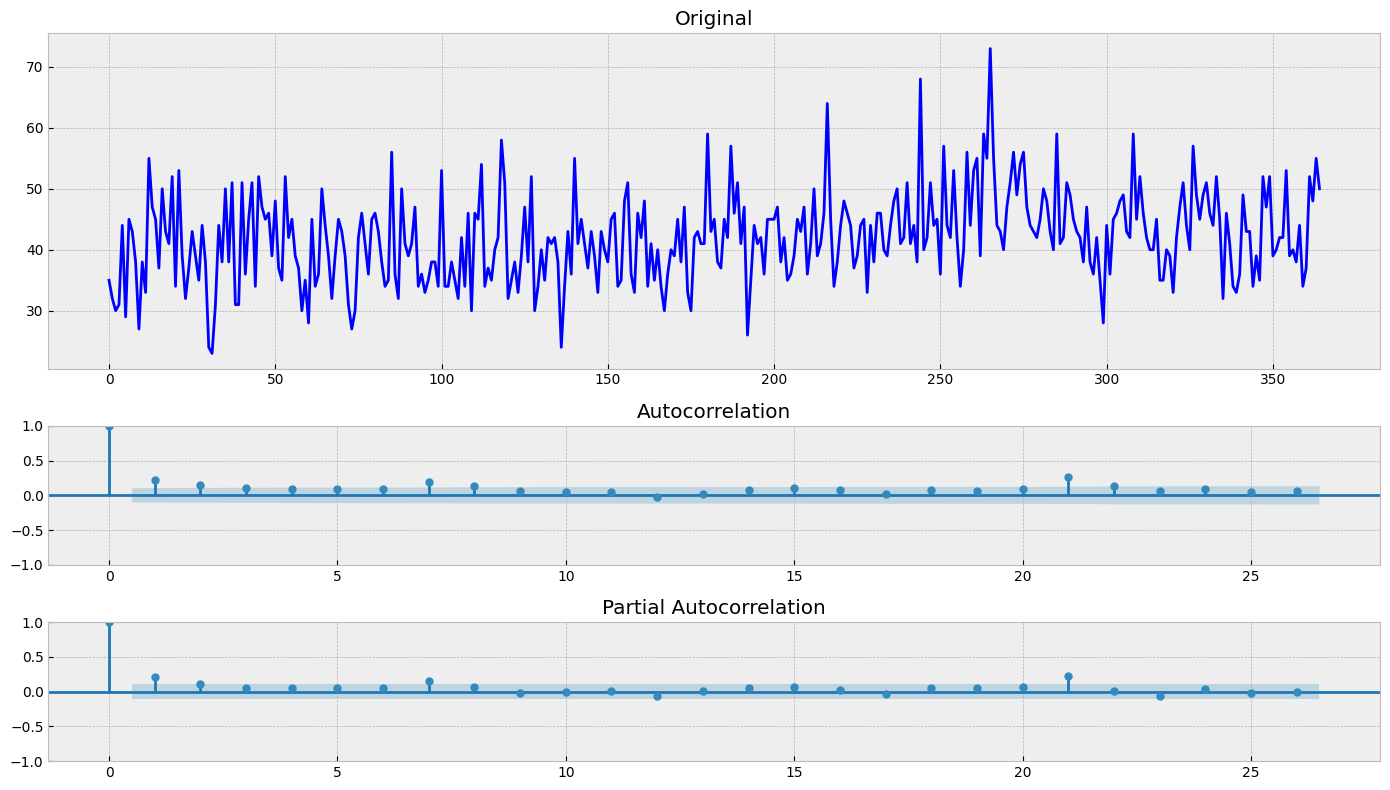

In [20]:
tsplot(female_births['Count'])

Визуально временной ряд "Daily total female births in California" стационарен, поскольку:
1. График похож на шум
2. Сезонность не наблюдается
3. Трендовая составляющая не прослеживается
4. Дисперсия устойчивая

Значение p-value < 0,05 (по тесту Дики-Фуллера). Значит, временной ряд стационарен, значения в нем не зависят от времени, средняя и дисперсия постоянны.

**Задаем класс SSA.**

Каждый экземпляр класса будет содержать декомпозицию временного ряда для некоторой длины окна  𝐿  и предоставлять полезные методы для анализа, построения и реконструкции временного ряда.

In [21]:
class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.

        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list.
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.

        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """

        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.

        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """

        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

**Алгоритм SSA:**
1. Для временного ряда $F = (f_0, \ f_1, \ldots, \ f_{N-1})$ и длины окна $L$ формируется матрица траекторий $\mathbf{X}$ со столбцами, заданными векторами $(f_i, \ldots, f_{L+i-1})^{\text{T}}$, $0 \le i \le N-L$.
2. Раскладка $\mathbf{X}$ с сингулярным разложением, $\mathbf{X} = \sum_{i=0}^{d-1}\sigma_i U_i V^{\text{T}}_i$.
3. Построение элементарные матрицы $d$ $\mathbf{X}_i = \sigma_i U_i V^{\text{T}}_i$.
4. По диагонали усредняется $\mathbf{X}_i$, чтобы сформировать элементарные компоненты временного ряда $\tilde{F}_i$, такие что $F = \sum_{i=0}^{d-1} \tilde{F}_i$.
5. Вычисление и сохранение взвешенной корреляционной матрицы $\mathbf{W}_{\text{corr}}$ для $\tilde{F}_i$.

Задача группировки и классификации элементарных компонентов $\tilde{F}_i$ остается за пользователем.

**Анализ ВР методом SSA с различными размерами окон (L)**

Определим максимальный размер окна.

In [27]:
round(len(female_births['Count']) / 2)

182

Для анализа используем следующие размеры окон: 2, 10, 30, 70, 120, 180

**L = 2**

Использование данной длины окна с практической точки зрения не является полезным, однако будем считать этот шаг отправной точкой для сравнительного наблюдения дальнейших разложений ВР на большее число компонент.



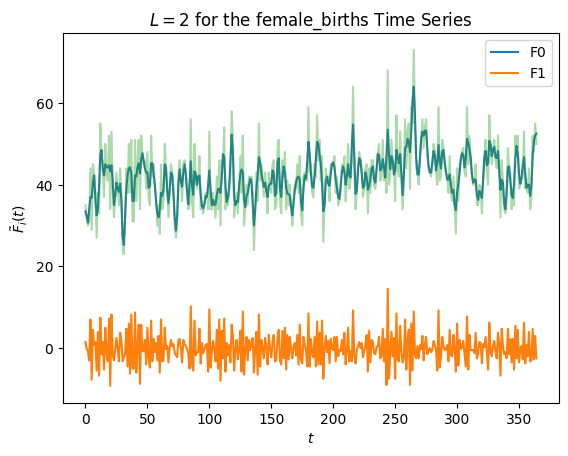

In [23]:
F_ssa_L2 = SSA(female_births['Count'], 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the female_births Time Series");

При  𝐿=2  возвращаются только два элементарных компонентов. Даже при такой небольшой длине окна алгоритм SSA начал отделять высокочастотный шум от ряда, давая нам несколько ослабленную версию исходного ряда в компоненте  𝐹̃0 .

**L=10**

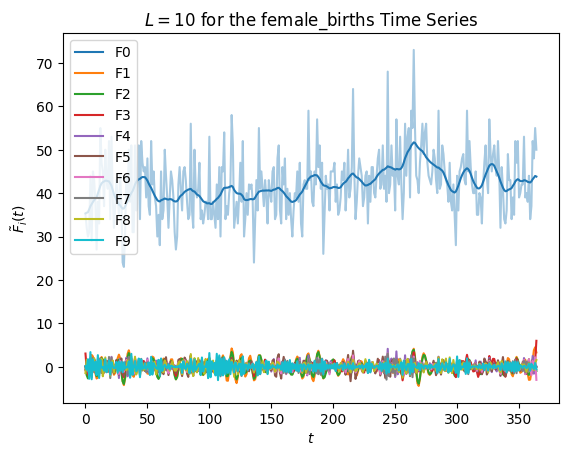

In [29]:
F_ssa_L10 = SSA(female_births['Count'], 10)
F_ssa_L10.components_to_df().plot()
F_ssa_L10.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=10$ for the female_births Time Series");

ВР более сглажен (F0). Возможно, при бОльшем размере окна мы сможем уловить тренд на каком-либо участке ВР.

Остальные компоненты шумовые и высокочастотные. Сезонность в нашем ВР отсутствует.

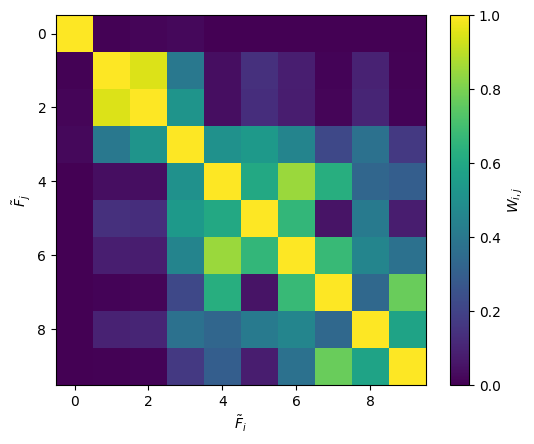

In [32]:
F_ssa_L10.plot_wcorr()

Корреляционная матрица также нам показывает, что компоненты с F1 по F9 скорее всего шумовые.

Вместе с тем, можно выделить 3 блока: F0, F1-F2, F3-F9 (явно шумовые)

**L=30**

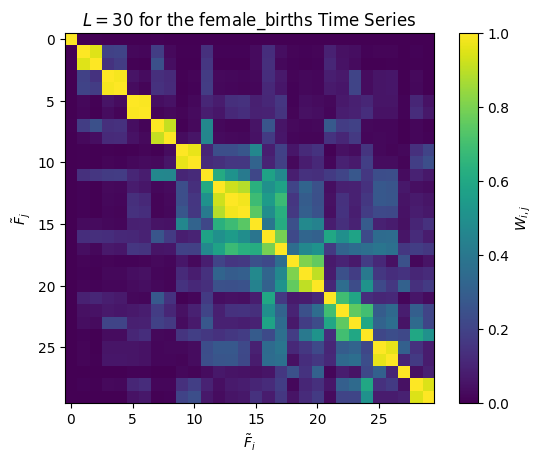

In [33]:
F_ssa_L30 = SSA(female_births['Count'], 30)
F_ssa_L30.plot_wcorr()
plt.title(r"$L=30$ for the female_births Time Series");

Ранее отмеченные 3 блока: F0, F1-F2, F3-F9 (явно шумовые), оставим без изменения.

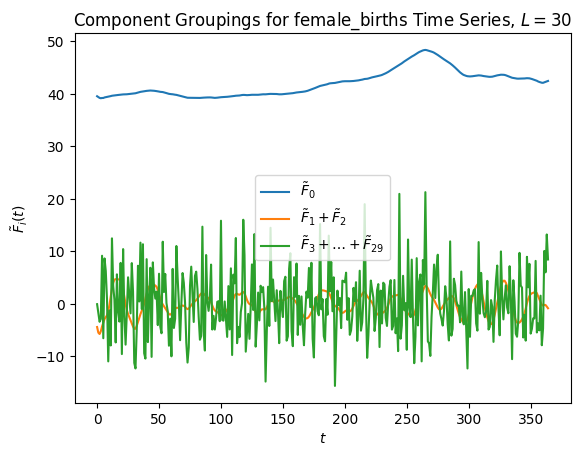

In [75]:
F_ssa_L30.reconstruct(0).plot()
F_ssa_L30.reconstruct([1,2]).plot()
F_ssa_L30.reconstruct(slice(3,30)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for female_births Time Series, $L=30$");
plt.legend([r"$\tilde{F}_0$",
            r"$\tilde{F}_1+\tilde{F}_2$",
            r"$\tilde{F}_3+ \ldots + \tilde{F}_{29}$"]);

Из графиков видно, что есть уровневая/трендовая компонента F0.

F1-F2 дают некую амплитуду.

Остальные компоненты шумовые.

**L=70**

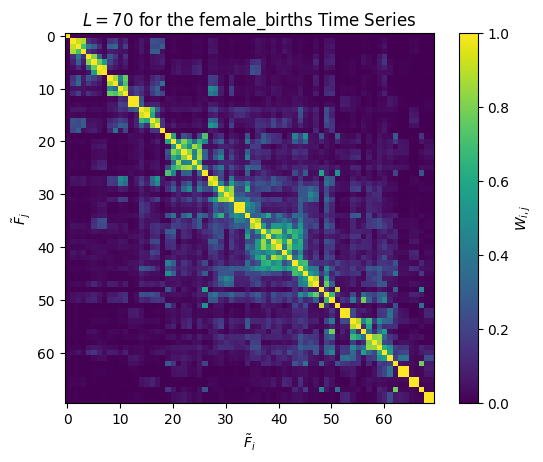

In [34]:
F_ssa_L70 = SSA(female_births['Count'], 70)
F_ssa_L70.plot_wcorr()
plt.title(r"$L=70$ for the female_births Time Series");

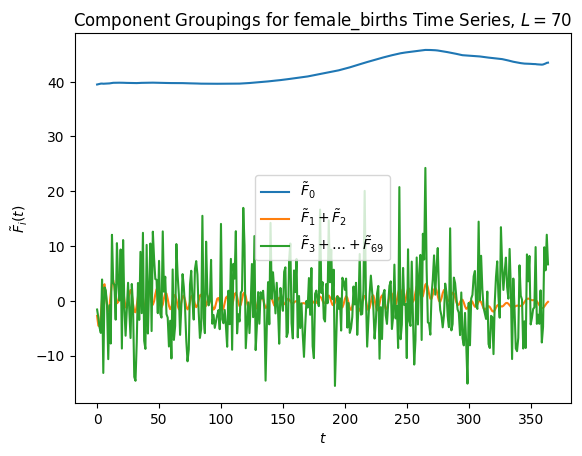

In [62]:
F_ssa_L70.reconstruct(0).plot()
F_ssa_L70.reconstruct([1,2]).plot()
F_ssa_L70.reconstruct(slice(3,69)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for female_births Time Series, $L=70$");
plt.legend([r"$\tilde{F}_0$",
            r"$\tilde{F}_1+\tilde{F}_2$",
            r"$\tilde{F}_3+ \ldots + \tilde{F}_{69}$"]);

**L=120**

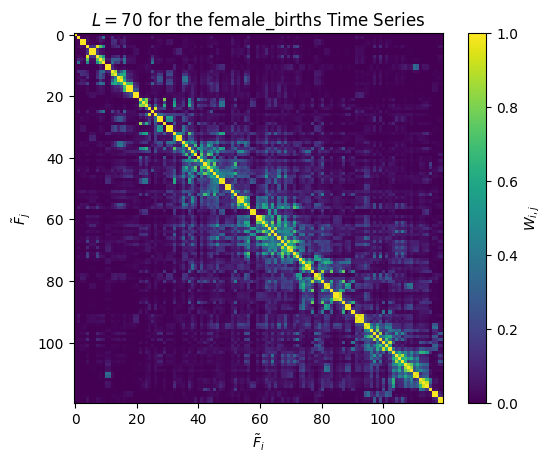

In [35]:
F_ssa_L120 = SSA(female_births['Count'], 120)
F_ssa_L120.plot_wcorr()
plt.title(r"$L=70$ for the female_births Time Series");

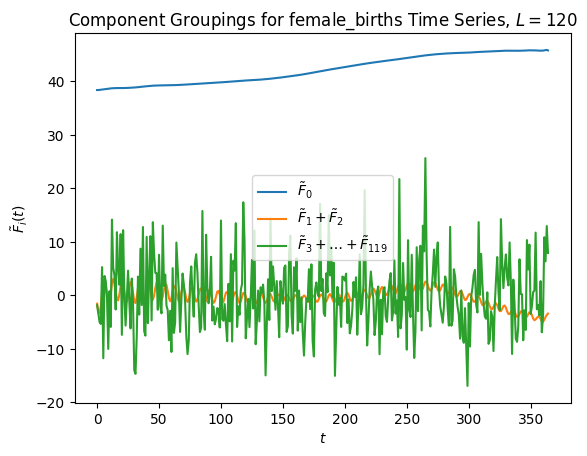

In [63]:
F_ssa_L120.reconstruct(0).plot()
F_ssa_L120.reconstruct([1,2]).plot()
F_ssa_L120.reconstruct(slice(3,119)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for female_births Time Series, $L=120$");
plt.legend([r"$\tilde{F}_0$",
            r"$\tilde{F}_1+\tilde{F}_2$",
            r"$\tilde{F}_3+ \ldots + \tilde{F}_{119}$"]);

**L=180**

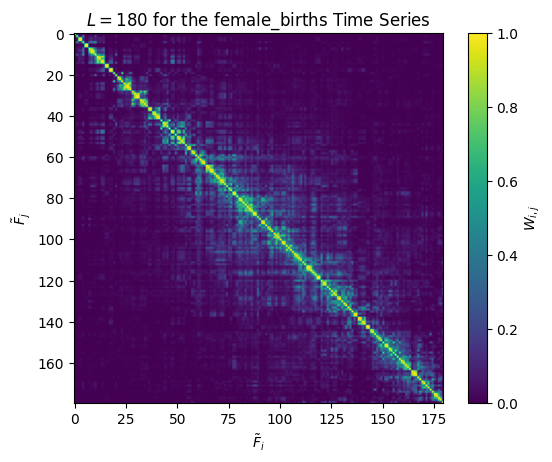

In [36]:
F_ssa_L180 = SSA(female_births['Count'], 180)
F_ssa_L180.plot_wcorr()
plt.title(r"$L=180$ for the female_births Time Series");

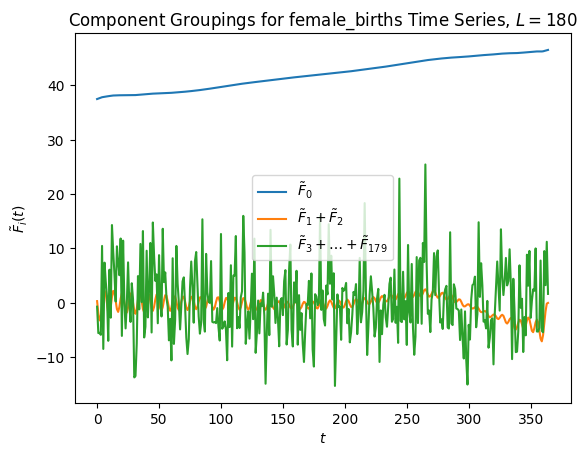

In [64]:
F_ssa_L180.reconstruct(0).plot()
F_ssa_L180.reconstruct([1,2]).plot()
F_ssa_L180.reconstruct(slice(3,119)).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for female_births Time Series, $L=180$");
plt.legend([r"$\tilde{F}_0$",
            r"$\tilde{F}_1+\tilde{F}_2$",
            r"$\tilde{F}_3+ \ldots + \tilde{F}_{179}$"]);

Интересно заметить, что в августе-сентябре (t в диапазоне 240-270 ) есть некая аномалия в поведении ВР.


Выведем шум на отдельный график

<Axes: >

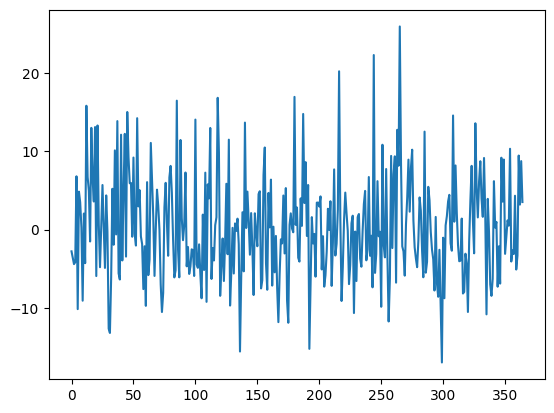

In [65]:
F_ssa_L180.reconstruct(slice(3,179)).plot(alpha=1)

Удалось установить уровень/частичный тренд.

Сравним оригинал и график восстановленый по 3 компонентам.

<Axes: >

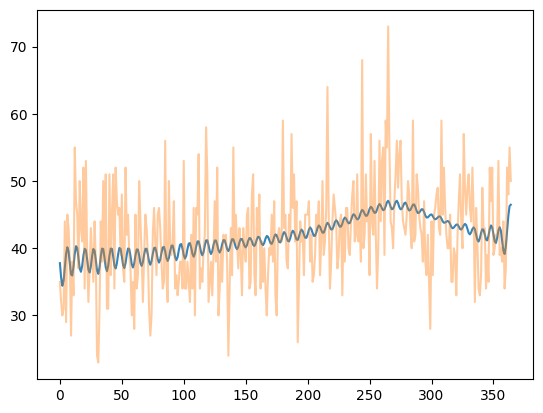

In [76]:
F_ssa_L180.reconstruct(slice(0,3)).plot(alpha=0.9)
F_ssa_L180.orig_TS.plot(alpha=0.4)

Объединение первых 3 элементарных компонент вместе и построение остальных:

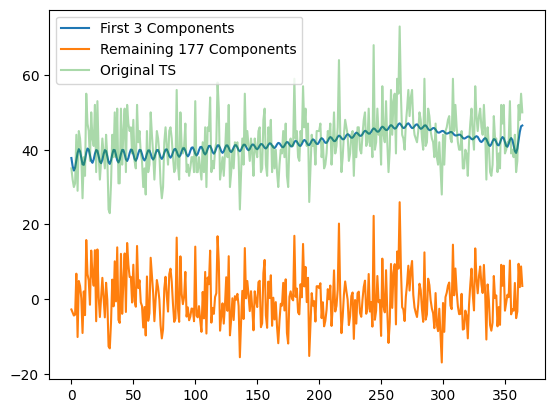

In [79]:
F_ssa_L180.reconstruct(slice(0,3)).plot()
F_ssa_L180.reconstruct(slice(3,179)).plot()
F_ssa_L180.orig_TS.plot(alpha=0.4)
plt.legend(["First 3 Components", "Remaining 177 Components", "Original TS"]);

Приведенный выше график показывает, что сумма первых 3 компонентов адекватно отражает основную, лежащую в основе периодичность временного ряда.

Сумма оставшихся 177 компонентов содержит высокочастотные случайные колебания.